# Saving and loading coordinates with asdf

- https://docs.sunpy.org/en/stable/generated/gallery/saving_and_loading_data/coordinates_in_asdf.html

In this example we are going to look at saving and loading collections of
coordinates with [asdf](https://asdf.readthedocs.io/en/latest/).

asdf is a modern file format designed to meet the needs of the astronomy
community. It has deep integration with Python and sunpy and Astropy as well as
implementations in other languages. It can be used to store known Python
objects in a portable, well defined file format. It is primarily useful for
storing complex Astropy and SunPy objects in a way that can be loaded back into
the same form as they were saved.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import asdf
import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import frames
from sunpy.data.sample import AIA_171_IMAGE
from sunpy.sun import constants

To get started let's use a function to get the coordinates of a semi-circular
loop from
[this](https://sunpy.org/posts/2018/2018-07-21-coronal-loop-coordinates.html)
blog post by Will Barnes to generate ourselves some coordinates.

In [ ]:
@u.quantity_input
def semi_circular_loop(length: u.cm, latitude: u.deg = 0*u.deg):
    """
    Return HGS coordinates for a semi-circular loop
    """
    angles = np.linspace(0, 1, 1000) * np.pi * u.rad
    z = length / np.pi * np.sin(angles)
    x = length / np.pi * np.cos(angles)
    hcc_frame = frames.Heliocentric(
        observer=frames.HeliographicStonyhurst(lon=0 * u.deg, lat=latitude, radius=constants.au))

    return SkyCoord(
        x=x,
        y=np.zeros_like(x),
        z=z + constants.radius,
        frame=hcc_frame)

Use this function to generate a `astropy.coordinates.SkyCoord` object.

In [ ]:
loop_coords = semi_circular_loop(500*u.Mm, 30*u.deg)
print(loop_coords.shape)
# print the first and last coordinate point
print(loop_coords[[0, -1]])

(1000,)
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 30., 1.49597871e+11)>): (x, y, z) in Mm
    [( 159.15494309, 0., 695.7), (-159.15494309, 0., 695.7)]>


This is a regular coordinate object that can be transformed to other frames
or overplotted on images. For instance we could overplot it on an AIA image

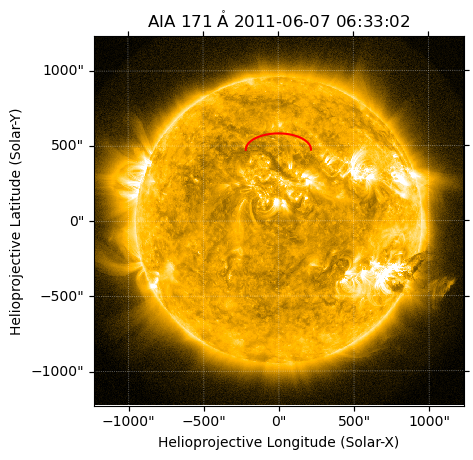

In [ ]:
aiamap = sunpy.map.Map(AIA_171_IMAGE)

fig = plt.figure()
ax = fig.add_subplot(projection=aiamap)
aiamap.plot(axes=ax, clip_interval=(1, 99.5) * u.percent)
ax.plot_coord(loop_coords, 'r')

plt.show()

We can now save these loop points to an asdf file to use later. The advantage
of saving them to asdf is that all the metadata about the coordinates will be
preserved, and when we load the asdf, we will get back an identical
`astropy.coordinates.SkyCoord` object.

asdf files save a dictionary to a file, so to save the loop coordinates we
need to put them into a dictionary. This becomes what asdf calls a tree.

In [ ]:
tree = {'loop_points': loop_coords}

with asdf.AsdfFile(tree) as asdf_file:
    asdf_file.write_to("loop_coords.asdf")

This asdf file is a portable file and can be safely loaded by anyone with
Astropy and sunpy installed. We can reload the file like so:

In [ ]:
with asdf.open("loop_coords.asdf") as input_asdf:
    new_coords = input_asdf['loop_points']

print(new_coords.shape)
# print the first and last coordinate point
print(new_coords[[0, -1]])

(1000,)
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=None, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 30., 1.49597871e+11)>): (x, y, z) in Mm
    [( 159.15494309, 0., 695.7), (-159.15494309, 0., 695.7)]>
